# Bitcoin Prediction using Deep Learning

This time, you will build a basic Neural Network model to predict Bitcoin price based on historical Data.
This notebook helps you to train a model but you can use it however you want.

In [ ]:
from google.colab import drive
import os
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
os.chdir("/content/drive/MyDrive/EI time series_GRP3")

In [ ]:
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers

from sklearn.preprocessing import MinMaxScaler

import helper_functions as hf


CURDIR = os.getcwd()
DATADIR = os.path.join(CURDIR,  "data")
FIGDIR = os.path.join(CURDIR,  "figure")
%matplotlib inline

# Import Data
Our Data come from https://blockchain.info/.

Here, we load data into a Pandas DataFrame

In [ ]:
df_blockchain = pd.read_csv(os.path.join(DATADIR, "df_blockchain.csv"), 
                            delimiter=",")

In [ ]:
df=df_blockchain.dropna()

In [ ]:
df.shape

(3533, 23)

In [ ]:
df_blockchain.head()

,Date,market-price,n-transactions-per-block,median-confirmation-time,hash-rate,difficulty,miners-revenue,trade-volume,blocks-size,avg-block-size,...,cost-per-transaction,n-unique-addresses,n-transactions,n-transactions-total,n-transactions-excluding-popular,output-volume,estimated-transaction-volume,estimated-transaction-volume-usd,total-bitcoins,market-cap
0,2011-09-13,6.88,45.908451,0.0,12.018816,1.777774e+06,52318.011503,0.0,592.190091,0.019009,...,7.666766,12622.0,6519.0,1497195.0,6519.0,358543.612114,58615.641320,403275.612279,7.257416e+06,5.022014e+07
1,2011-09-14,6.19,42.465753,0.0,13.263925,1.755425e+06,48306.468911,0.0,594.907367,0.018007,...,7.369408,12408.0,6200.0,1503780.0,6200.0,302619.024544,74521.484625,461287.989830,7.264662e+06,4.540930e+07
2,2011-09-15,5.92,41.500000,0.0,12.914875,1.755425e+06,60431.444952,0.0,597.554226,0.018240,...,7.333913,12988.0,6474.0,1509972.0,6474.0,299226.130646,79422.402932,470180.625359,7.272284e+06,4.322228e+07
3,2011-09-16,5.58,52.176471,0.0,10.995096,1.755425e+06,34345.021913,0.0,600.362512,0.022136,...,5.466341,12059.0,6209.0,1516381.0,6209.0,674606.861338,82696.853247,461448.441118,7.279040e+06,4.088136e+07
4,2011-09-17,5.18,40.701493,0.0,10.733308,1.755425e+06,36805.913687,0.0,602.995510,0.017116,...,6.489054,10988.0,5454.0,1522600.0,5454.0,354198.945778,68238.166521,353473.702578,7.285375e+06,3.801833e+07


# Explore Dataset

We already explored dataset before, but you can draw other plots to analyse data if you want.

Idea : you can use pandas_profiling 

```python
from pandas_profiling import ProfileReport
ProfileReport(df)
```

In [ ]:
df_blockchain.columns

Index(['Date', 'market-price', 'n-transactions-per-block',
       'median-confirmation-time', 'hash-rate', 'difficulty', 'miners-revenue',
       'trade-volume', 'blocks-size', 'avg-block-size', 'transaction-fees',
       'transaction-fees-usd', 'cost-per-transaction-percent',
       'cost-per-transaction', 'n-unique-addresses', 'n-transactions',
       'n-transactions-total', 'n-transactions-excluding-popular',
       'output-volume', 'estimated-transaction-volume',
       'estimated-transaction-volume-usd', 'total-bitcoins', 'market-cap'],
      dtype='object')

In [ ]:
# get columns (You can add more columns to analyse results)
columns=['market-price','market-cap']
dataset = df[columns]

In [ ]:
dataset


,market-price,market-cap
0,6.88,5.022014e+07
1,6.19,4.540930e+07
2,5.92,4.322228e+07
3,5.58,4.088136e+07
4,5.18,3.801833e+07
...,...,...
3538,40784.32,7.379873e+11
3539,37280.35,6.998509e+11
3540,37528.30,6.642670e+11
3541,34754.54,6.847955e+11


# Data scaling

Here we scale the price between 0 and 1, this will help the optimization algorithm converge faster.

In [ ]:
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset.values.reshape(-1,len(columns)))

In [ ]:
dataset

array([[7.20668100e-05, 2.72726066e-05],
       [6.12095832e-05, 2.32181724e-05],
       [5.69611031e-05, 2.13750126e-05],
       ...,
       [5.90475789e-01, 5.59810096e-01],
       [5.46830366e-01, 5.77110932e-01],
       [6.09362486e-01, 6.01751769e-01]])

In [ ]:
dataset.shape

(3544, 2)

# Process data (Making sequences)

here we split and process data before training.

LSTM layer as an input layer expects the data to be 3 dimensions, we will use 'process_data' function to split data into sequences of a fixed length (rnn_size).

The neural network is expecting to have an input's shap of [batch_size, rnn_size, nb_features]

In [ ]:
dataset

array([[7.20668100e-05, 2.72726066e-05],
       [6.12095832e-05, 2.32181724e-05],
       [5.69611031e-05, 2.13750126e-05],
       ...,
       [5.46830366e-01, 5.77110932e-01],
       [6.09362486e-01, 6.01751769e-01],
       [6.04357304e-01, 6.01780043e-01]])

In [ ]:
# split datatest into data_train, data_valid and data_test
#data_train = dataset[:2000]
#data_valid = dataset[2000:2700]
#data_test = dataset[2700:3544]
# your code here

data_train = dataset[:2650]
data_valid = dataset[2650:3200]
data_test = dataset[3200:]

In [ ]:
def process_data(data, rnn_size=3, target_id=0, columns_size=len(columns)):
    X = []
    y = []
    for i in range(len(data)-rnn_size):
        X.append(data[i:i+rnn_size,:])
        y.append(data[i+rnn_size,0])
    return np.array(X).astype(np.float32).reshape((-1,rnn_size,columns_size)), np.array(y).astype(np.float32)

In [ ]:
# process data for RNN
X_train, y_train = process_data(data_train)
X_val, y_val = process_data(data_valid)
X_test, y_test = process_data(data_test)

In [ ]:
y_train


array([5.1611165e-05, 4.5317120e-05, 4.2799504e-05, ..., 5.3577740e-02,
       5.4843631e-02, 5.2017290e-02], dtype=float32)

In [ ]:
X_val.shape

(547, 3, 12)

In [ ]:
X_test.shape

(341, 3, 12)

# Deep Learning Model

Here we initialize the model using Keras.

Here we propose to code a basic neural network LSTM + Dense, but you are free to use any architecture.

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM
import tensorflow as tf
rnn_size=3

In [ ]:
regressor = keras.Sequential()
regressor.add(LSTM(128, input_shape=(rnn_size,len(columns)), activation='relu', return_sequences=True))
regressor.add(Dropout(0.2))

regressor.add(LSTM(64, activation='relu'))
regressor.add(Dropout(0.2))


regressor.add(Dense(32, activation='relu'))
regressor.add(Dropout(0.2))

regressor.add(Dense(1, activation=tf.keras.activations.linear))
opt = tf.keras.optimizers.Adam()
regressor.compile(optimizer='adam',
loss='mean_squared_error',metrics=['mean_squared_error'])

In [ ]:
# neural network model

# Build the model
#regressor = keras.Sequential()
#opt = keras.optimizers.Adam(learning_rate=0.001)
#Compiling the Recurrent Neural Network with adam optimier and 'mean_absolute_error' as loss function
#regressor.compile(loss='mean_absolute_error', optimizer=opt)

In [ ]:
#Fitting the Recurrent Neural Network
regressor.fit(X_train, y_train, validation_data = (X_val, y_val), batch_size = 16, epochs = 30)

Epoch 1/30
166/166 [==============================] - 4s 10ms/step - loss: 5.2484e-04 - mean_squared_error: 5.2484e-04 - val_loss: 1.2292e-04 - val_mean_squared_error: 1.2292e-04
Epoch 2/30
166/166 [==============================] - 1s 8ms/step - loss: 1.7901e-04 - mean_squared_error: 1.7901e-04 - val_loss: 1.2109e-04 - val_mean_squared_error: 1.2109e-04
Epoch 3/30
166/166 [==============================] - 1s 9ms/step - loss: 1.5244e-04 - mean_squared_error: 1.5244e-04 - val_loss: 1.3195e-04 - val_mean_squared_error: 1.3195e-04
Epoch 4/30
166/166 [==============================] - 1s 8ms/step - loss: 1.6738e-04 - mean_squared_error: 1.6738e-04 - val_loss: 1.1467e-04 - val_mean_squared_error: 1.1467e-04
Epoch 5/30
166/166 [==============================] - 1s 8ms/step - loss: 1.6339e-04 - mean_squared_error: 1.6339e-04 - val_loss: 2.3554e-04 - val_mean_squared_error: 2.3554e-04
Epoch 6/30
166/166 [==============================] - 1s 8ms/step - loss: 1.5368e-04 - mean_squared_error: 1.

# Evaluation

In [ ]:
# compute prediction for test
y_pred = regressor.predict([X_test])

In [ ]:
y_pred.shape


(341, 1)

In [ ]:
# compute rmse for test
import math
rnn_size=3
y_pred_inverse = scaler.inverse_transform(np.concatenate([y_pred, data_test[-len(y_pred):,1:]], axis=1))
y_test_inverse = scaler.inverse_transform(data_test.reshape(-1,len(columns)))[rnn_size:]
MAPE=np.divide(np.abs(np.subtract(y_test_inverse[0:len(y_test_inverse),0],y_pred_inverse[0:len(y_pred_inverse),0])),y_test_inverse[0:len(y_test_inverse),0]).mean()
MSE=np.square(np.subtract(y_test_inverse[0:len(y_test_inverse),0],y_pred_inverse[0:len(y_pred_inverse),0])).mean()
rmse_score=math.sqrt(MSE)
MAE=np.abs(np.subtract(y_test_inverse[0:len(y_test_inverse),0],y_pred_inverse[0:len(y_pred_inverse),0])).mean()
print("rmse score : ", rmse_score)
print("MAPE score :", MAPE)
print("MAE score :", MAE)


rmse score :  4838.999652778676
MAPE score : 0.07609785355004407
MAE score : 3165.186130388717


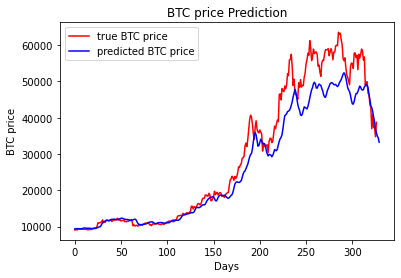

In [ ]:
#Graphs for predicted values
plt.plot(y_test_inverse[rnn_size:,0], color = 'red', label = 'true BTC price')
plt.plot(y_pred_inverse[:,0], color = 'blue', label = 'predicted BTC price')
plt.title('BTC price Prediction')
plt.xlabel('Days')
plt.ylabel('BTC price')
plt.legend()
plt.show()


#plt.plot(np.subtract(y_test_inverse[rnn_size:,0],y_pred_inverse[:,0]))

In [ ]:
# If you get this far, you can : 
- Test other neural network models
- Test other optimizers
- Compare results between Arima and RNN models
- Find a way to choose most important variables
- Implement a trading algorithm

SyntaxError: ignored



```

```

# Trading bot

In [ ]:
from google.colab import drive
import os
drive.mount('/content/drive')
import os
os.chdir("/content/drive/MyDrive/EI time series")
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.preprocessing import MinMaxScaler
import helper_functions as hf
CURDIR = os.getcwd()
DATADIR = os.path.join(CURDIR,  "data")
FIGDIR = os.path.join(CURDIR,  "figure")
%matplotlib inline
df_blockchain = pd.read_csv(os.path.join(DATADIR, "df_blockchain.csv"), 
                            delimiter=",")

df=df_blockchain.dropna()
columns=['market-price','market-cap']
dataset = df[columns]
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset.values.reshape(-1,len(columns)))

data_train = dataset[:2650]
data_valid = dataset[2650:3200]
data_test = dataset[3200:]

def process_data(data, rnn_size=3, target_id=0, columns_size=len(columns)):
    X = []
    y = []
    for i in range(len(data)-rnn_size):
        X.append(data[i:i+rnn_size,:])
        y.append(data[i+rnn_size,0])
    return np.array(X).astype(np.float32).reshape((-1,rnn_size,columns_size)), np.array(y).astype(np.float32)


# process data for RNN
X_train, y_train = process_data(data_train)
X_val, y_val = process_data(data_valid)
X_test, y_test = process_data(data_test)

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM
import tensorflow as tf
rnn_size=3

regressor = keras.Sequential()
regressor.add(LSTM(128, input_shape=(rnn_size,len(columns)), activation='relu', return_sequences=True))
regressor.add(Dropout(0.2))

regressor.add(LSTM(64, activation='relu'))
regressor.add(Dropout(0.2))


regressor.add(Dense(32, activation='relu'))
regressor.add(Dropout(0.2))

regressor.add(Dense(1, activation=tf.keras.activations.linear))
opt = tf.keras.optimizers.Adam()
regressor.compile(optimizer='adam',
loss='mean_squared_error',metrics=['mean_squared_error'])

#Fitting the Recurrent Neural Network
regressor.fit(X_train, y_train, validation_data = (X_val, y_val), batch_size = 16, epochs = 30)

y_pred = regressor.predict([X_test])

#we only select what we need for the trading
df=df[['Date','market-price','trade-volume']].loc[len(df['market-price'])-len(y_pred_inverse):len(df['market-price'])]
df.set_index("Date", inplace=True)
df.fillna(method="ffill", inplace=True)  # if there are gaps in data, use previously known values
df.dropna(inplace=True)
print(df.head())  
df.shape
SEQ_LEN = 60  # how long of a preceeding sequence to collect for RNN
FUTURE_PERIOD_PREDICT = 3  # how far into the future are we trying to predict?
def classify(current, future):
    if float(future) > float(current):
        return 1
    else:
        return 0
df=df.assign(prediction=y_pred_inverse[:,0])
df['future'] = df['prediction'].shift(-FUTURE_PERIOD_PREDICT)
df['target'] = list(map(classify, df['market-price'], df['future']))
budget= 555555555066
Bitcoin=0 
for i in df['target']:
  if i==0 and Bitcoin != 0: 
    budget+=Bitcoin*df['market-price'][i]
    Bitcoin=0
  elif i==1  and budget>0:
    Bitcoin+=budget//df['market-price'][i]
    budget=0

print('budget=',budget)
print('Bitcoin=',Bitcoin)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Epoch 1/30
166/166 [==============================] - 3s 8ms/step - loss: 6.2807e-04 - mean_squared_error: 6.2807e-04 - val_loss: 4.5394e-05 - val_mean_squared_error: 4.5394e-05
Epoch 2/30
166/166 [==============================] - 1s 7ms/step - loss: 1.4603e-04 - mean_squared_error: 1.4603e-04 - val_loss: 9.3940e-05 - val_mean_squared_error: 9.3940e-05
Epoch 3/30
166/166 [==============================] - 1s 7ms/step - loss: 1.5304e-04 - mean_squared_error: 1.5304e-04 - val_loss: 1.1648e-04 - val_mean_squared_error: 1.1648e-04
Epoch 4/30
166/166 [==============================] - 1s 7ms/step - loss: 1.4299e-04 - mean_squared_error: 1.4299e-04 - val_loss: 7.0722e-05 - val_mean_squared_error: 7.0722e-05
Epoch 5/30
166/166 [==============================] - 1s 7ms/step - loss: 1.3434e-04 - mean_squared_error: 1.3434e-04 - val_loss: 5.7808e-05 - val_mean_squared

ValueError: ignored

# Nouvelle section

In [ ]:
df=df_blockchain
#we only select what we need for the trading
df=df[['Date','market-price']].loc[len(df['market-price'])-len(y_pred_inverse):len(df['market-price'])]
df.set_index("Date", inplace=True)
df.fillna(method="ffill", inplace=True)  # if there are gaps in data, use previously known values
df.dropna(inplace=True)
print(df.head())  
df.shape

            market-price
Date                    
2020-07-01       9133.97
2020-07-02       9236.38
2020-07-03       9087.98
2020-07-04       9072.42
2020-07-05       9131.31


(330, 1)

In [ ]:
def classify(current, future):
    if float(future) > 1.0*float(current):
        return 1
    else:
        return 0

In [ ]:
def classifyTH(current, future,TH):
    if float(future) > TH*float(current):
        return 1
    else:
        return 0

In [ ]:
df=df.assign(prediction=y_pred_inverse[:,0])
df['future'] = df['prediction'].shift(-3)


In [ ]:
df['target'] = list(map(classify, df['market-price'], df['future']))
df=df.dropna()
df

,market-price,prediction,future,target
Date,,,,
2020-07-01,9133.97,9355.787860,9447.105241,1
2020-07-02,9236.38,9370.648194,9427.986245,1
2020-07-03,9087.98,9419.073074,9395.314721,1
2020-07-04,9072.42,9447.105241,9357.610836,1
2020-07-05,9131.31,9427.986245,9375.857645,1
...,...,...,...,...
2021-05-19,42912.19,41716.895941,36997.309700,0
2021-05-20,36964.27,40317.816073,35811.922430,0
2021-05-21,40784.32,38788.266027,34926.473004,0


In [ ]:
budget= 50000
Bitcoin=0 

for i in df['target']:
  if i==0 and Bitcoin != 0: 
    budget+=Bitcoin*df['future'][i]
    Bitcoin=0
  elif i==1  and budget>0:
    Bitcoin+=budget/df['future'][i]
    budget=0
def classifyTH(current, future,TH):
    if float(future) > TH*float(current):
        return 1
    else:
        return 0
  

print('budget=',budget)
print('Bitcoin=',Bitcoin)



budget= 50919.99161192271
Bitcoin= 0


In [ ]:

I=[]
Budget=[]
for i in range(5000,10000):
  I.append(i)
  budget= i
  Bitcoin=0 
  for i in df['target']:
    if i==0 and Bitcoin != 0: 
      budget+=Bitcoin*df['future'][i]
      Bitcoin=0
    elif i==1  and budget>0:
      Bitcoin+=budget/df['future'][i]
      budget=0
  Budget.append(budget)

print('budget=',Budget)
print('Bitcoin=',Bitcoin)






budget= [5091.99916119227, 5093.01756102451, 5094.035960856747, 5095.054360688987, 5096.072760521225, 5097.091160353464, 5098.109560185701, 5099.1279600179405, 5100.146359850179, 5101.164759682417, 5102.183159514658, 5103.201559346895, 5104.21995917913, 5105.238359011371, 5106.256758843609, 5107.27515867585, 5108.293558508089, 5109.311958340325, 5110.330358172562, 5111.348758004801, 5112.367157837039, 5113.385557669279, 5114.403957501517, 5115.422357333756, 5116.440757165996, 5117.459156998229, 5118.477556830471, 5119.4959566627085, 5120.514356494948, 5121.532756327188, 5122.551156159426, 5123.569555991661, 5124.587955823904, 5125.6063556561385, 5126.624755488376, 5127.643155320616, 5128.661555152855, 5129.679954985092, 5130.698354817334, 5131.71675464957, 5132.735154481809, 5133.7535543140475, 5134.771954146286, 5135.790353978527, 5136.808753810763, 5137.827153643003, 5138.8455534752375, 5139.863953307477, 5140.882353139718, 5141.900752971955, 5142.919152804193, 5143.937552636431, 514

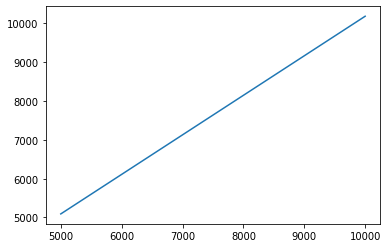

In [ ]:
plt.plot(I,Budget)

In [ ]:
df=df_blockchain
#we only select what we need for the trading
df=df[['Date','market-price']].loc[len(df['market-price'])-len(y_pred_inverse):len(df['market-price'])]
df.set_index("Date", inplace=True)
df.fillna(method="ffill", inplace=True)  # if there are gaps in data, use previously known values
df.dropna(inplace=True)
print(df.head())  
df.shape

def classifyTH(current, future,TH):
    if float(future) > TH*float(current):
        return 1
    else:
        return 0
df=df.assign(prediction=y_pred_inverse[:,0])
df['future'] = df['prediction'].shift(-3)

I=np.arange(1,1.2,0.01)
Budget=[]
for i in I:
  TH= i

  df['target'] = list(map(classifyTH, df['market-price'], df['future'],[TH]*len(df['market-price'])))
  df=df.dropna()

  budget=50000
  Bitcoin=0 
  for i in df['target']:
    if i==0 and Bitcoin != 0: 
      budget+=Bitcoin*df['future'][i]
      Bitcoin=0
    elif i==1  and budget>0:
      Bitcoin+=budget/df['future'][i]
      budget=0
  Budget.append(budget)

print('budget=',Budget)
print('Bitcoin=',Bitcoin)






            market-price
Date                    
2020-07-01       9133.97
2020-07-02       9236.38
2020-07-03       9087.98
2020-07-04       9072.42
2020-07-05       9131.31
budget= [50919.99161192271, 51438.39269038632, 52704.19064061135, 54330.33049965933, 51230.40192745137, 50406.81502948428, 50202.99544324236, 50101.3949123387, 50000, 50000, 50000, 50000, 50000, 50000, 50000, 50000, 50000, 50000, 50000, 50000]
Bitcoin= 0


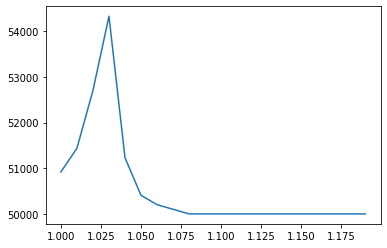

In [ ]:
plt.plot(I,Budget)